# Spring Fruits Benchmark

## Abstract

Benchmarks are tricky to do well, and the results are often hard to interpret. This analysis attempts to go beyond a simple headline number to explore how performance varies with data set size for two different frameworks (Spring and Quarkus) running the same application. The results show that while one framework may outperform another at a given data set size, the performance characteristics can change as the data set size changes, leading to different conclusions about scalability and efficiency. The result is a deeper insight into how each framework handles increasing loads and the factors that influence their performance.

For a data set size `N`, the cycle time (inverse throughput) is linear in `N`, so `t = A + B*N`, with `A` a baseline framework cost per HTTP request, and `B` the processing time per data item. We measure `A` and `B` for a simple endpoint that fetches and renders a complete data set in JSON. `A` is small (on the order of tens of microseconds), and Quarkus is the smaller of the two, so it performs better in benchmarks with small data sets by up to a factor of 2. For the application we measured, `B` was smaller for Spring, so for larger data sets Spring has better results - faster than Quarkus for `N>~40`. Probably for a "real" application (not just CRUD) the processing `B` will be comparable and the two frameworks will converge, leaving the two frameworks roughly identical for large data sets, and less dramatically different for small data sets.

## Introduction and Set Up

The application code is taken from the benchmarks available at https://github.com/quarkusio/spring-quarkus-perf-comparison. The data represent fruits with links to the stores that stock them and the prices listed. The `/fruits` endpoint returns a list of fruits and prices per store in JSON format. As in the original code, the Spring Boot application has 3 important configuration tweaks that bring the raw performance in the original tests to within roughly 70% of the Quarkus results. In addition we removed the observability features from the Spring sample to bring it in line with the Quarkus one, which adds a few percent to the throughput over the original. The original benchmarks only covered one data set with 10 fruits; this analysis extends that to multiple data sets by increasing numbers of fruits to observe performance trends. The measurements are done with the Spring benchmarks harness, which is similar to the Quarkus one, and the baseline results for 10 fruits are similar to the original. The numbers reported here were collected in a controlled environment on a Linux virtual machine with 16 vCPUs and 32 GB RAM, running Java 21. The application, database and the load generator were all running on the same VM to minimize network variability, but in separate containers, constrained to have a fixed amount of CPUs and memory (4 CPUs and 2GB for the application container unless mentioned otherwise).

First a bit of housekeeping: set up Python libraries:

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Results

Here are the raw data for throughput (TPS) vs number of fruits (N). The larger data sets were generated simply by copying the original 10-fruit data set multiple times. The number of stores is constant and the number of prices per fruit is the same in each case, so the result set size scales linearly with the number of fruits.

In [44]:
df = pd.DataFrame({
    'N':              [10,          20,         40,          80   ],
    'spring-fruits':  [14892,       10941,      7329,        4541 ],
    'quarkus-fruits': [20022,       11770,      6996,        3952 ]
})
df

,N,spring-fruits,quarkus-fruits
0,10,14892,20022
1,20,10941,11770
2,40,7329,6996
3,80,4541,3952


Now we do some anaysis and plot the data along with a linear regression of the "cycle time" (inverse of throughput) vs number of fruits.

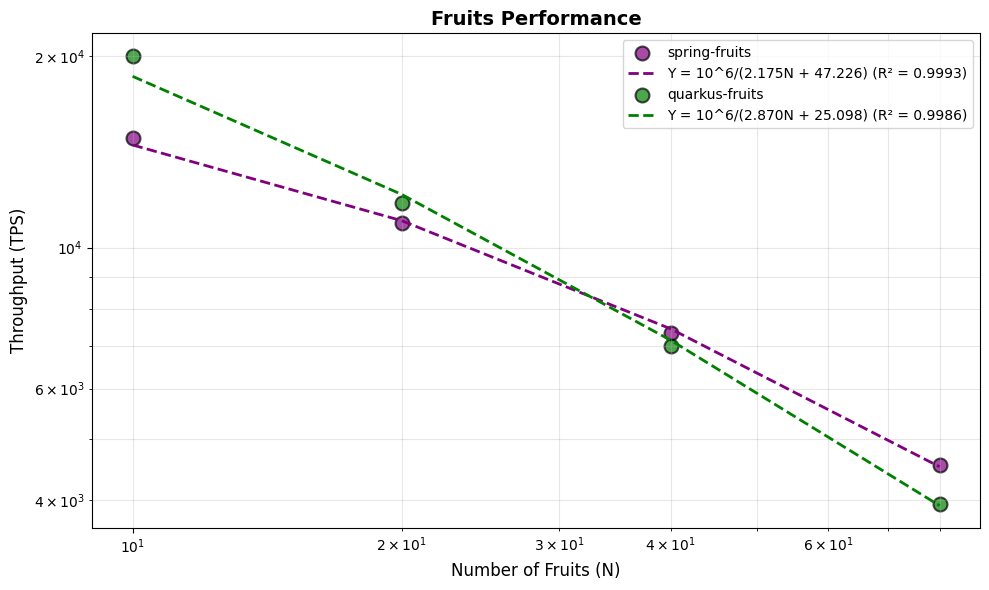

In [45]:
# Calculate regression for both data series
slope1, intercept1, r_value1, _, _ = stats.linregress(df['N'], 10**6/df['spring-fruits'])
trend1 = slope1 * df['N'] + intercept1

slope2, intercept2, r_value2, _, _ = stats.linregress(df['N'], 10**6/df['quarkus-fruits'])
trend2 = slope2 * df['N'] + intercept2

# Create plot with both data series
plt.figure(figsize=(10, 6))

# First series in purple
plt.scatter(df['N'], df['spring-fruits'], color='purple', marker='o', s=100, alpha=0.7, 
            edgecolors='black', linewidth=1.5, label='spring-fruits')
plt.plot(df['N'], 10**6/trend1, color='purple', linewidth=2, linestyle='--',
         label=f'Y = 10^6/({slope1:.3f}N + {intercept1:.3f}) (R² = {r_value1**2:.4f})')

# Second series in green
plt.scatter(df['N'], df['quarkus-fruits'], color='green', marker='o', s=100, alpha=0.7, 
            edgecolors='black', linewidth=1.5, label='quarkus-fruits')
plt.plot(df['N'], 10**6/trend2, color='green', linewidth=2, linestyle='--',
         label=f'Y = 10^6/({slope2:.3f}N + {intercept2:.3f}) (R² = {r_value2**2:.4f})')

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of Fruits (N)', fontsize=12)
plt.ylabel('Throughput (TPS)', fontsize=12)
plt.title('Fruits Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## Analysis and Interpretation

Here's a reasonable interpretation: time spent per fruit is roughly constant, and there is a fixed overhead per framework. So `(cycle time) = 1 / throughput = A + B*N` (`A` and `B` constant). The trendlines show a good fit to that for both data sets.

In [46]:
bf = pd.DataFrame({'spring-fruits': [intercept1, slope1], 'quarkus-fruits': [intercept2, slope2]}, index=['A (microsec)', 'B (microsec/fruit)'])
bf

,spring-fruits,quarkus-fruits
A (microsec),47.226316,25.097797
B (microsec/fruit),2.175362,2.869939


`B` is smaller for Spring so eventually the Spring app gets faster than the Quarkus one, even though the constant framework cost `A` is higher.

In a more realistic application where the cycles time per fruit is higher, the two frameworks would converge their scaling, leaving the two frameworks roughly identical for large data sets, and less dramatically different for small data sets. The baseline framework overhead would be less significant in that case, and since it is only a few tens of microseconds, any processing of a data item that took 100ms or a few times that would quickly overwhelm it even for small data sets.